In [1]:
import os
import torch

path = "/home/lnhang/Final_cases/classifier_data/couette_APG/"

# 读取path下的所有文件
files = os.listdir(path)

# print(files)

In [2]:
# 读取path下的所有文件夹，分类别存储

# 读取Re6500开头的文件
Re6500_files = []
Re22360_files = []

for file in files:
    if file.startswith("Re6500"):
        Re6500_files.append(file)
    elif file.startswith("Re22360"):
        Re22360_files.append(file)
        
# print(Re6500_files)
# print(Re22360_files)

# 读取"_"后面的字符串，去掉“m”后转换为数字
Re6500_files = sorted(Re6500_files, key=lambda x: int(x.split("_")[1][1:]))
Re22360_files = sorted(Re22360_files, key=lambda x: int(x.split("_")[1][1:]))

print(Re6500_files)
print(Re22360_files)

Re6500_paths = []
Re22360_paths = []

for file in Re6500_files:
    Re6500_paths.append(path + file)
    
for file in Re22360_files:
    Re22360_paths.append(path + file)

['Re6500_m0', 'Re6500_m100', 'Re6500_m150', 'Re6500_m200', 'Re6500_m250', 'Re6500_m300']
['Re22360_m0', 'Re22360_m380', 'Re22360_m550', 'Re22360_m750', 'Re22360_m800', 'Re22360_m1000']


In [3]:
Re6500_timestep = 10000
Re22360_timestep = 20000
uTau = 0.052
correct_U = 1

In [4]:
def read_openfoam_field_to_tensor(path, field_name, patch_name="internalField"):
        """
        read the file from the given path and return the field tensor
        """
        file_path = os.path.join(path, field_name)
        with open(file_path, 'r') as f:
            lines = f.readlines()

        find_patch = False
        start = False
        data = []

        for line in lines:
            if start and find_patch:
                if line.startswith(')'):
                    break
                # 如果不是注释或空行，则处理数据
                stripped_line = line.strip().replace('(', '').replace(')', '')
                if not stripped_line.startswith("//") and stripped_line:
                    # 将每个值映射到浮点数，然后转换成列表
                    data.append(list(map(float, stripped_line.split())))
            elif patch_name in line:
                find_patch = True
            elif find_patch and "(" in line:
                start = True

        field = torch.tensor(data)
        return field

In [5]:
from collections import deque
import re
from vtk.util.numpy_support import vtk_to_numpy
import vtk
import numpy as np


def create_triangles(path):
        """
        This function creates triangles for the mesh from the given cell connectivity information.

        To ensure that no edges are used more than twice, which can lead to overlapping triangles
        and inconsistencies in the mesh, the following rules are applied:

        1. If one of the neighbors is in created_indices, continue 

        2. If all neighbors not in created_indices, create triangles

        """

        created_indices = set()

        visited_indices = set()

        queue = deque()

        cell_connectivity = get_cell_connectivity(path)

        triangles = []

        # start from the first cell
        start_cell = list(cell_connectivity.keys())[0]
        queue.append(start_cell)
        visited_indices.add(start_cell)

        while queue:
            current_cell = queue.popleft()
            neighbors = cell_connectivity[current_cell]

            for neighbor in neighbors:
                if neighbor not in visited_indices:
                    queue.append(neighbor)
                    visited_indices.add(neighbor)

            if not any(neighbor in created_indices for neighbor in neighbors):
                # All neighbors are not in created_indices
                # Create triangles
                for i in range(len(neighbors)):
                    for j in range(i+1, len(neighbors)):
                        triangles.append([current_cell, neighbors[i], neighbors[j]])
                created_indices.add(current_cell)
            else:
                continue

        return triangles
    
def get_cell_connectivity(path):
    """
    get the connectivity of the cells

    input:
        - path: the path of the case

    output:
        - connectivity: a dict with the cells as keys and the neighbor cells as values : {cell: [cell1, cell2]}
    """
    # read the owner and neighbour file
    owner, neighbor, nInternalFaces = read_mesh_information(path)

    # for each cell, get the neighbor cells
    connectivity = {}
    for i in range(nInternalFaces):
        cell1 = owner[i]
        cell2 = neighbor[i]
        if cell1 not in connectivity:
            connectivity[cell1] = [cell2]
        else:
            connectivity[cell1].append(cell2)

        if cell2 not in connectivity:
            connectivity[cell2] = [cell1]
        else:
            connectivity[cell2].append(cell1)

    return connectivity

def read_mesh_information(path):
    """
    Read the owner and neighbor file

    input:
        - path: the path of the case

    output:
        - owner: the owner of the cells
        - neighbor: the neighbor of the cells
        - nInternalFaces: the number of internal faces
    """
    # read the owner file
    owner_file = os.path.join(path, "constant/polyMesh/owner")
    neighbor_file = os.path.join(path, "constant/polyMesh/neighbour")

    # read the nInternalFaces
    nInternalFaces = 0
    with open(neighbor_file, "r") as f:
        for line in f:
            if "nInternalFaces" in line:
                match = re.search("nInternalFaces:\s*(\d+)", line)
                if match:
                    nInternalFaces = int(match.group(1))
                break

    # use the nInternalFaces to read the owner and neighbor
    owner = []
    neighbor = []

    with open(owner_file, "r") as f:
        start_reading = False
        for line in f:
            line = line.strip()
            if line.startswith("("):
                start_reading = True
                continue
            elif line.startswith(")"):
                break
            if start_reading:
                owner.extend([int(i) for i in line.split()])

    with open(neighbor_file, "r") as f:
        start_reading = False
        for line in f:
            line = line.strip()
            if line.startswith("("):
                start_reading = True
                continue
            elif line.startswith(")"):
                break
            if start_reading:
                neighbor.extend([int(i) for i in line.split()])

    if nInternalFaces == 0:
        nInternalFaces = len(neighbor)

    return owner, neighbor, nInternalFaces

def get_internal_coordinates(path):
    """
    Get the cell center of the internal cells

    input:
        - path: the path of the case

    output:
        - Internal_coordinates: the coordinates of the internal cells
    """
    # vtk file path 
    # if not exist, create the vtk file
    if not os.path.exists(path+"/VTK"):
        os.system("cd "+path+" && foamToVTK")

    vtk_file = get_dir_file_name(path+"/VTK/")
    vtk_path = os.path.join(path, "VTK/"+vtk_file)

    # load the internal.vtu
    internal_path = os.path.join(vtk_path, "internal.vtu")
    Internal_coordinates = get_vtu_cell_center(internal_path)
    return Internal_coordinates

def get_dir_file_name(path):
    """
    Get the vtk file name

    input:
        - path: the path of the case

    output:
        - vtk_file: the name of the vtk file
    """
    # Initialize variable for the directory name
    dir_name = None

    # Regex pattern to match folder ending with _<number>
    pattern = re.compile(r"_\d+$")

    # Iterate over the items in the path
    for item in os.listdir(path):
        # Check if the item is a directory and matches the pattern
        if os.path.isdir(os.path.join(path, item)) and pattern.search(item):
            dir_name = item
            break

    # Handling the case where no matching directory is found
    if dir_name is None:
        raise FileNotFoundError("No directory matching the pattern found")

    return dir_name

def get_vtu_cell_center(path):
    """
    Get the cell center of the vtu file

    input:
        - path: the path of the vtu file

    output:
        - cells_coordinates: the coordinates of the cells
    """
    # load the mesh
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(path)
    reader.Update()
    vtu_data = reader.GetOutput()

    # get coordinates
    cellCentersFilter = vtk.vtkCellCenters()
    cellCentersFilter.SetInputData(vtu_data)
    cellCentersFilter.Update()

    cellCenters = cellCentersFilter.GetOutput()
    np_cellCenters = vtk_to_numpy(cellCenters.GetPoints().GetData())

    x = np_cellCenters[:, 0]
    y = np_cellCenters[:, 1]

    cell_coordinates = np.vstack((x, y)).T

    return cell_coordinates


triangle = create_triangles(Re6500_paths[0])
internal_coordinates = get_internal_coordinates(Re6500_paths[0])


In [6]:
Re6500_velocities, Re22360_velocities = [], []

for path in Re6500_paths:
    timestep_path = os.path.join(path, str(Re6500_timestep))
    velocity = read_openfoam_field_to_tensor(timestep_path, "U", "internalField")
    Re6500_velocities.append(velocity)
    
for path in Re22360_paths:
    timestep_path = os.path.join(path, str(Re22360_timestep))
    velocity = read_openfoam_field_to_tensor(timestep_path, "U", "internalField")
    Re22360_velocities.append(velocity)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

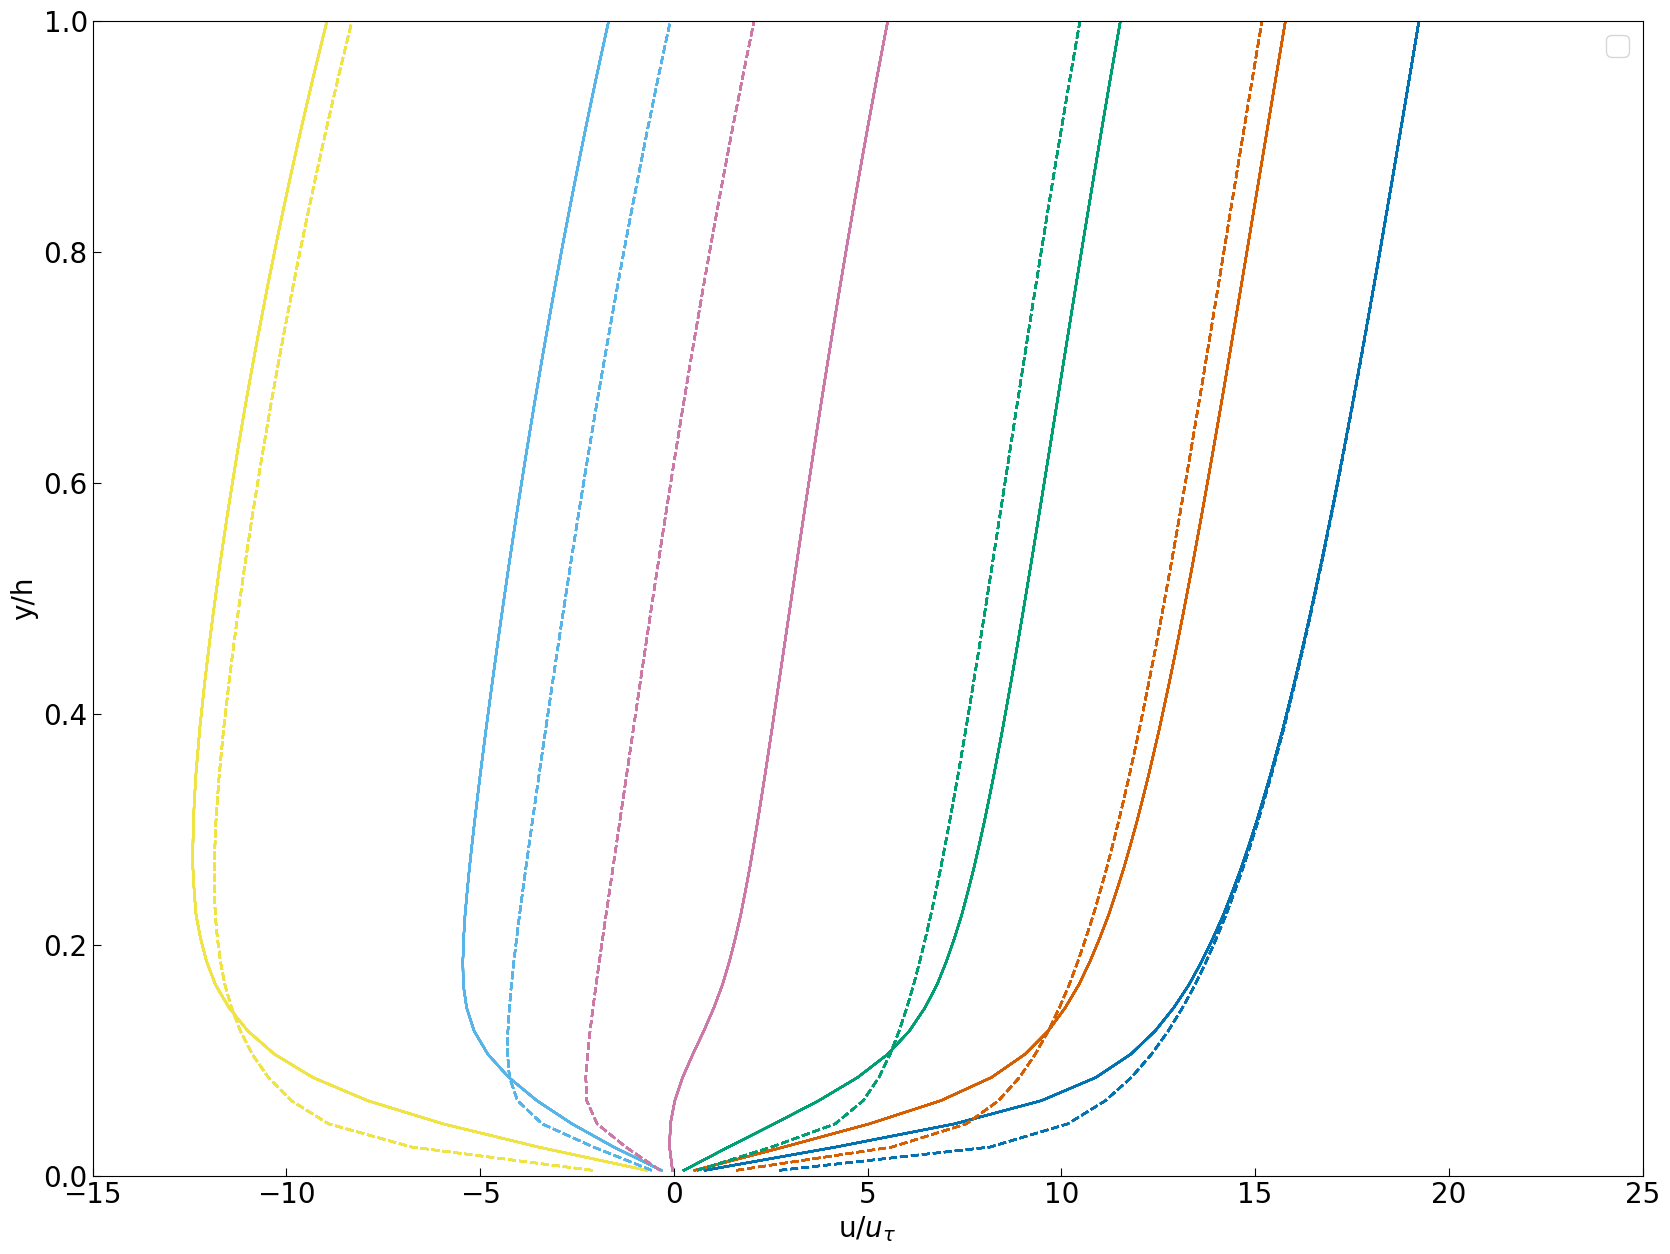

In [15]:
from matplotlib.tri import Triangulation
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from matplotlib import pyplot as plt

def plot_streamlines(U, coordinates, ax, steps=1000, step_size=1, back=False):
        
        from scipy.interpolate import LinearNDInterpolator
        
        
        def velocity_interpolator(U, coordinates):
            U_x = U[:, 0].detach().numpy().flatten()
            U_y = U[:, 1].detach().numpy().flatten()
            return LinearNDInterpolator(coordinates, U_x), LinearNDInterpolator(coordinates, U_y)

        def rk2_step(xi, yi, U_x_interp, U_y_interp, h=0.1):
            # 第一步
            vx1, vy1 = U_x_interp(xi, yi), U_y_interp(xi, yi)
            k1x, k1y = h * vx1, h * vy1

            # 第二步
            vx2, vy2 = U_x_interp(xi + 0.5 * k1x, yi + 0.5 * k1y), U_y_interp(xi + 0.5 * k1x, yi + 0.5 * k1y)
            k2x, k2y = h * vx2, h * vy2
            return xi + k2x, yi + k2y
        
        
        U_x_interp, U_y_interp = velocity_interpolator(U, coordinates)
        
        X_cor = 3
        
        seed_points = [(X_cor, y) for y in np.linspace(0.1, 2, 20)]

        for x0, y0 in seed_points:
            xs, ys = [x0], [y0]
            x, y = x0, y0
            h = -step_size if back else step_size
            for _ in range(steps):
                x, y = rk2_step(x, y, U_x_interp, U_y_interp, h)
                xs.append(x)
                ys.append(y)
            ax.plot(xs, ys, 'k', linewidth=1)

from matplotlib.ticker import MaxNLocator

def show_velocity_distribution(velocity, internal_coordinates, triangle):
    """
    Show the velocity distribution

    input:
        - velocity: the velocity field
        - internal_coordinates: the coordinates of the internal cells
        - triangle: the triangles of the mesh
    """
    x = internal_coordinates[:, 0]
    y = internal_coordinates[:, 1]

    triang = Triangulation(x, y, triangle)

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    
    contour = ax.tricontourf(
        triang,
        velocity[:, 0].detach().numpy().flatten(),
        levels=100, cmap='jet',vmin=-0.01, vmax=0.04)
    
    plot_streamlines(velocity, internal_coordinates, ax)
    plot_streamlines(velocity, internal_coordinates, ax, back=True)
    
    ax.set_xlabel("X", fontsize=20)
    ax.set_ylabel("Y", fontsize=20)
    
    # Set tick parameters to make the ticks inside and set font size
    ax.tick_params(axis='both', which='major', labelsize=20, direction='in', length=6, width=2)
    ax.tick_params(axis='both', which='minor', labelsize=15, direction='in', length=4, width=1)
    
    # Set the axis limits
    ax.set_xlim([0, 9])
    ax.set_ylim([0, 3.0])
    
    # Force major ticks to be at 5 locations and minor ticks in between
    # ax.xaxis.set_major_locator(MaxNLocator(5))
    # ax.yaxis.set_major_locator(MaxNLocator(5))
    
    # # Optionally, set minor ticks
    # ax.xaxis.set_minor_locator(MaxNLocator(5))
    # ax.yaxis.set_minor_locator(MaxNLocator(5))
    
    cbar = plt.colorbar(contour, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    
    plt.show()
    
def plot_velocity_profile(U, internal_coordinates, fig=None, ax=None, label=None, color=None, linestyle=None):
    """
    Plot the velocity profile.

    Interpolate all the velocity components to the same x coordinate 
    and plot the velocity profile.

    Parameters:
    - U: Velocity field (assumed to be a tensor with at least one velocity component).
    - internal_coordinates: Array of shape (N, 2) containing the x and y coordinates.
    - fig: Optional matplotlib figure object. If None, a new figure will be created.
    - ax: Optional matplotlib axes object. If None, a new axes will be created.

    Returns:
    - fig: The matplotlib figure object used for plotting.
    - ax: The matplotlib axes object used for plotting.
    """
    import numpy as np
    from scipy.interpolate import griddata
    import matplotlib.pyplot as plt

    # Extract X and Y coordinates
    X = internal_coordinates[:, 0]
    Y = internal_coordinates[:, 1]

    # Generate new x points for interpolation
    new_x_points = np.linspace(X.min(), X.max(), 20)

    # Create figure and axes if not provided
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(20, 8))
    
    # set color
    if color is None:
        color = 'b'
    
    # set linestyle
    if linestyle is None:
        linestyle = '-'

    # Loop over each new x point and interpolate the velocity profile
    for new_x in new_x_points:
        # Create a mask to select points near the current x value
        mask = (X >= new_x - (X.max() - X.min()) / 20) & (X <= new_x + (X.max() - X.min()) / 20)
        local_X = X[mask]
        local_Y = Y[mask]

        # Extract the velocity component (assuming U is a PyTorch tensor)
        local_U = U[mask][:, 0].numpy()

        # Skip if there are not enough points for interpolation
        if len(local_Y) < 2:
            continue

        # Generate new y points for interpolation
        new_y_points = np.linspace(local_Y.min(), local_Y.max(), 100)

        # Perform linear interpolation
        U_interpolated = griddata((local_X, local_Y), local_U, (new_x, new_y_points), method='linear')

        # Replace NaN values with nearest-neighbor interpolation
        U_interpolated = np.where(
            np.isnan(U_interpolated), 
            griddata((local_X, local_Y), local_U, (new_x, new_y_points), method='nearest'), 
            U_interpolated
        )

        # Plot the interpolated velocity profile
        if new_x == new_x_points[0]:
            ax.plot((U_interpolated + correct_U) / uTau, new_y_points, label=label, color=color, linestyle=linestyle)
        else:
            ax.plot((U_interpolated + correct_U) / uTau, new_y_points, color=color, linestyle=linestyle)

    # Set axis labels and font sizes
    ax.set_xlabel("u/$u_{\\tau}$", fontsize=20)
    ax.set_ylabel("y/h", fontsize=20)

    # Set tick parameters
    ax.tick_params(axis='x', direction='in', length=6, labelsize=20)
    ax.tick_params(axis='y', direction='in', length=6, labelsize=20)

    # Set axis limits
    ax.set_ylim([0, 1])
    ax.set_xlim([-15, 25])

    # Add legend and grid
    ax.legend(fontsize=20)
    # ax.grid(True)

    # Return the figure and axes objects
    return fig, ax

fig, ax = plt.subplots(figsize=(20, 15))

colors = ["#0072B2", "#D55E00", "#009E73", "#CC79A7", "#56B4E9", "#F0E442"]
for i, velocity in enumerate(Re6500_velocities):
    plot_velocity_profile(velocity, internal_coordinates, fig=fig, ax=ax, label=None, color=colors[i], linestyle='-')
    
for i, velocity in enumerate(Re22360_velocities):
    plot_velocity_profile(velocity, internal_coordinates, fig=fig, ax=ax, label=None, color=colors[i], linestyle='--')